In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from sympy import *
from sympy.physics.mechanics import dynamicsymbols, init_vprinting, msubs
from IPython.display import Image
from IPython.core.display import HTML
import scipy.integrate
import math
from numpy.linalg import matrix_power
from scipy.linalg import expm, sinm, cosm

%matplotlib notebook

In [3]:
def discretize_ss(A, B, dt):
    A_B = np.block([[A, B],
                [np.zeros((B.shape[1], A.shape[0])), np.zeros((B.shape[1], B.shape[1]))]])
    #print("A shape:", A.shape)
    #print("B shape:", B.shape)
    #print("A_B:", A_B)

    eAt_d = scipy.linalg.expm(A_B * dt)

    A_d_temp = eAt_d[:A.shape[0], :A.shape[0]]

    B_d_temp = eAt_d[:B.shape[0], A.shape[0]:]

    return (A_d_temp, B_d_temp)

In [40]:
def get_integrated_position_trajectory():
    x_ref_temp = np.zeros((n, N))

    pos_desired = 0.0
    for i in range(0, N):
        if i < N/4 * 2:
            vel_desired = 0.5
        elif t < N/4:
            vel_desired = -0.5
        elif t > N/4:
            vel_desired = 0
        pos_desired += vel_desired * dt
        x_ref_temp[:, i] = np.array([0, 0, 0, 0, 0, pos_desired, 0, 0, 0, 0, 0, vel_desired, -9.81])
        
    return x_ref_temp

U shape after init: (6, 30)
X shape after init: (13, 31)
avg_psi: 0.0
U_t shape after init: (6, 30)
X_t shape after init: (13, 31)
Minimum possible Force in X and Y direction: -50.0
Maximum possible Force in X and Y direction: 50.0
Entering main MPC loop...
Final MPC iterations: 451


<IPython.core.display.Javascript object>


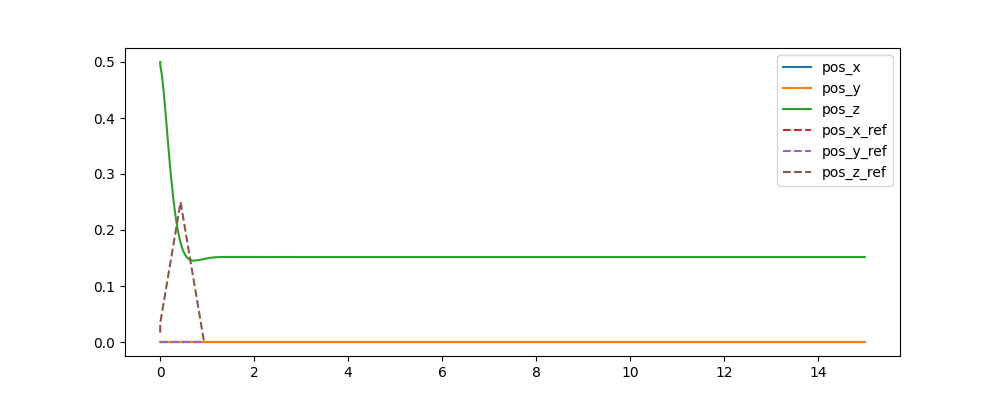

<IPython.core.display.Javascript object>


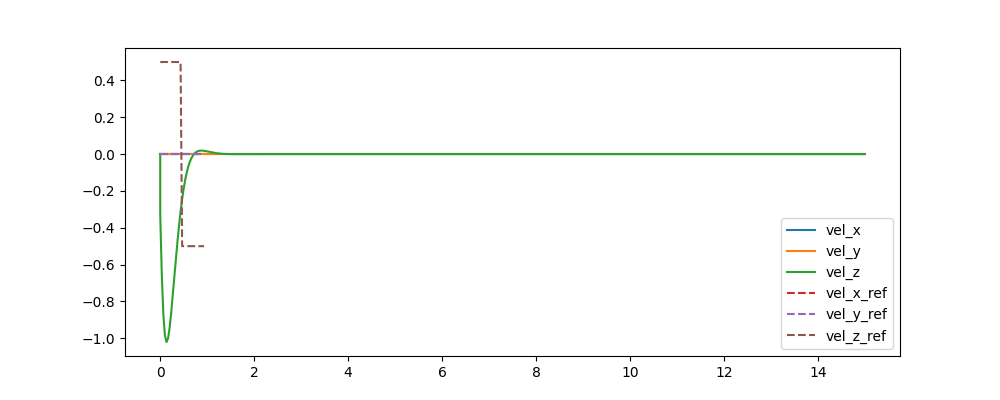

<IPython.core.display.Javascript object>


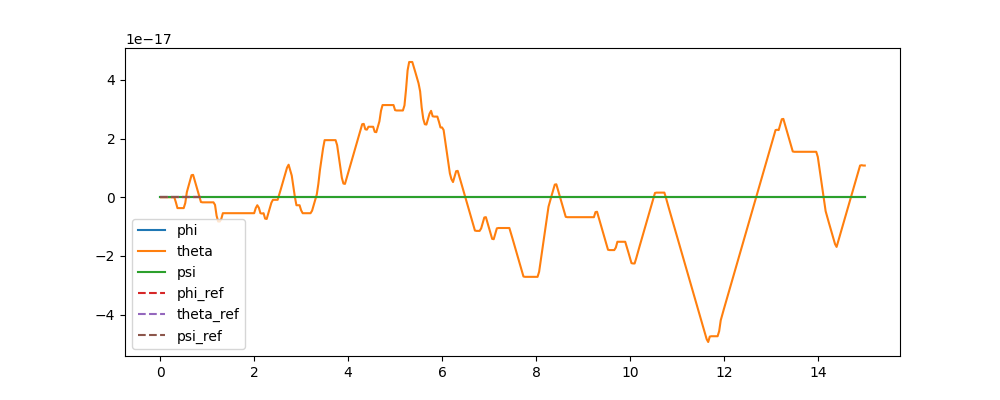

<IPython.core.display.Javascript object>


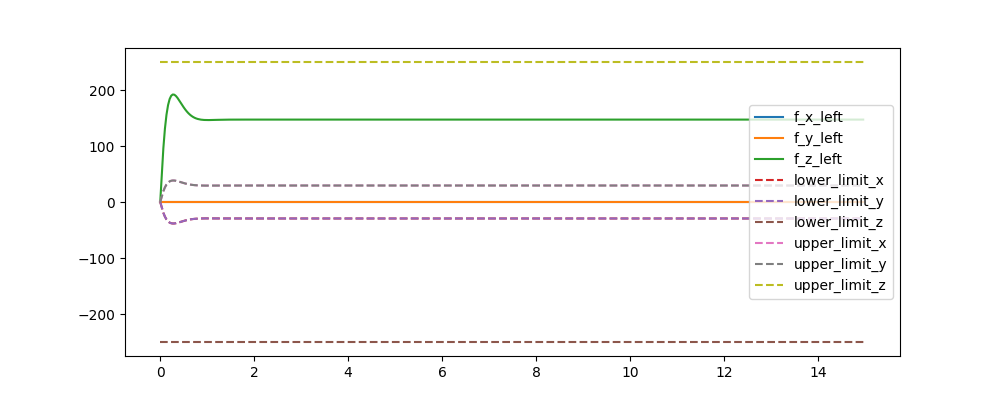

<IPython.core.display.Javascript object>


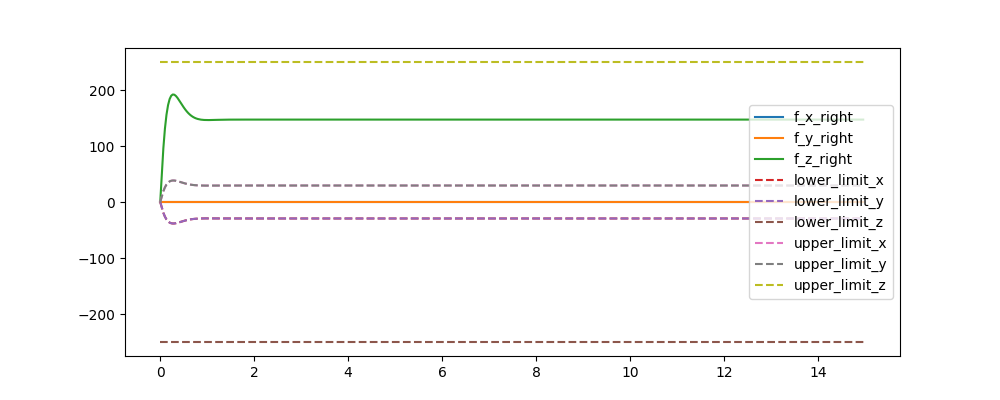

In [50]:
############################ MPC for full point mass model #######################################################

from casadi import *

dt = 1/30 # [s] (sampling time interval)
N = 30 # Prediction horizon Length

f_min = -250 # Minimum Force 
f_max = 250 # Maximum Force. Replace with max force in x, z, and z

phi = SX.sym('phi') # Orientation Euler Angle 1
theta = SX.sym('theta') # Orientation Euler Angle 2
psi = SX.sym('psi') # Orientatoin Euler Angle 3

omega_x = SX.sym('omega_x')
omega_y = SX.sym('omega_y')
omega_z = SX.sym('omega_z')

p_x = SX.sym('p_x') # position X
p_y = SX.sym('p_y') # position Y
p_z = SX.sym('p_z') # position Z

v_x = SX.sym('v_x') # velocity X
v_y = SX.sym('v_y') # velocity Y
v_z = SX.sym('v_z') # velocity Z

g_constant = SX.sym('g') # gravity state / constant (is augmented to allow state space form), might be seperated again for readability

states = [phi, theta, psi, p_x, p_y, p_z, omega_x, omega_y, omega_z, v_x, v_y, v_z, g_constant]
n = len(states)

f_x_l = SX.sym('f_x_l') # Force in X on left foot
f_y_l = SX.sym('f_y_l') # Force in Y on left foot
f_z_l = SX.sym('f_z_l') # Force in Z on left foot

f_x_r = SX.sym('f_x_r') # Force in X on right foot
f_y_r = SX.sym('f_y_r') # Force in Y on right foot
f_z_r = SX.sym('f_z_r') # Force in Z on right foot

controls = [f_x_l, f_y_l, f_z_l, f_x_r, f_y_r, f_z_r]
m = len(controls)

U = SX.sym('U', m, N) # Control action matrix (that will be determined by the NLP solver)
X = SX.sym('X', n, N + 1) # State Matrix (that will also be determined by the NLP solver due to the chosen multiple-shooting method). The + 1 is for x0
P = SX.sym('P', n, 1 + N) # Parameter Matrix containing states and reference states. n + n to have n elements for the initial state and n elements for the reference state.

print("U shape after init:", U.shape)
print("X shape after init:", X.shape)

objective_function = 0 # expression for the objective function

# lbx = lower bounds on optimization variable(s)
# ubx = upper bounds on optimization variable(s)
# lbg = lower bounds on constraints vector (should also be a vector), for equality constraints, just set lbg=ubg=k, where k is the constraint value
# ubg = upper bounds on constraints vector (should also be a vector)

lbx = []
ubx = []
lbg = []
ubg = []

g = [] # Constraint vector (both equality and inequality)

g += [X[:, 0] - P[:, 0]] # equality constraint x0 (chosen by solver) - x0 (input as parameter by user) = 0

lbg += [0] * n # n zeroes for equality constraints. These exist to ensure solver and actual initial state are the same.
ubg += [0] * n # n zeroes for equality constraints. These exist to ensure solver and actual initial state are the same.

#print("lbg length after initial state constraint:", len(lbg))

Q = np.diag([10,10,10,1000,1000,1000,10,10,10,10,10,10,0])

R = np.diag([0.001, 0.001, 0.001, 0.001, 0.001, 0.001])

t = 0

# state is phi, theta, psi, p_x, p_y, p_z, omega_x, omega_y, omega_z, v_x, v_y, v_z, gravity constant

x_t = [0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, -9.81]

x_ref = get_integrated_position_trajectory()

m_value = 30 # kg

# For now, the desired state is constant, when that will change, the average angle will have to be calculated from the time-varying state trajectory.
avg_psi = np.mean(x_ref[2, :])
print("avg_psi:", avg_psi)

I_world = np.array([[0.1536, 0., 0.],
                    [0., 0.6288, 0.],
                    [0., 0., 0.6843]]) # Inertia in the world frame. See symbolic definiton with rotation matrix from body frame above.

# Location of the force vector being applied by the left foot.
r_x_left = 0.15
r_y_left = 0
r_z_left = 0

# Location of the force vector being applied by the right foot.
r_x_right = -0.15
r_y_right = 0
r_z_right = 0


# Skew symmetric versions for the 3x1 foot position vector resembling the matrix version of the cross product of two vectors. This is needed for the matrix form.
r_left_skew_symmetric = np.array([[0, -r_z_left, r_y_left],
                                  [r_z_left, 0, -r_x_left],
                                  [-r_y_left, r_x_left, 0]]) 
    
r_right_skew_symmetric = np.array([[0, -r_z_right, r_y_right],
                                   [r_z_right, 0, -r_x_right],
                                   [-r_y_right, r_x_right, 0]])

A_c = np.array([[0, 0, 0, 0, 0, 0, math.cos(avg_psi), math.sin(avg_psi), 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, -math.sin(avg_psi), math.cos(avg_psi), 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                    
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                    
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                    
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

B_c = np.block([[0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [I_world @ r_left_skew_symmetric, I_world @ r_right_skew_symmetric],
                [1/m_value, 0, 0, 1/m_value, 0, 0],
                [0, 1/m_value, 0, 0, 1/m_value, 0],
                [0, 0, 1/m_value, 0, 0, 1/m_value],
                [0, 0, 0, 0, 0, 0]])

A_d, B_d = discretize_ss(A_c, B_c, dt)

for i in range(N):
    #print("i:", i)
    
    state = X[:, i] # extract state at current time step
    control = U[:, i] # extract control input at current time step
    
    # Add the symbolic cost for each time step to the objective function 
    objective_function = objective_function + (state - P[:, i+1]).T @ Q @ (state - P[:, i+1]) + control.T @ R @ control
    
    #This is the equality constraint required for multiple shooting, so that the solver respects the system dynamics
    next_state = X[:, i+1]
    next_state_simulation = A_d @ state + B_d @ control
    #print("next_state_simulation:", next_state_simulation)
    #print("next state simulation type:", type(next_state_simulation))
    
    g += [next_state - next_state_simulation]
    
    lbg += [0] * n # n zeroes for equality constraints enforcing system dynamcis on every state
    ubg += [0] * n # n zeroes for equality constraints enforcing system dynamcis on every state
        

adjust_friction_constraints = True
mu = 0.2

adjust_contact_constraints_equality = True
adjust_contact_constraints_bounds = False

if adjust_contact_constraints_equality:

    #Diagonal ones where contact is not present. First 3 rows is left foot, second 3 rows is right foot
    D = np.array([[0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0]])

    for i in range(N): # Contact constraints.
        
        if i % m == 0:
            g += [D @ U[:, i]]
            lbg += [0] * m
            ubg += [0] * m

for i in range(N): # Friction cone constraints. Seperate loops to have a nice structure in constraints

    if adjust_friction_constraints:
        if i % m == 0:
            
            f_x_left = U[0, i]
            f_y_left = U[1, i]
            f_z_left = U[2, i]
            
            f_x_right = U[3, i]
            f_y_right = U[4, i]
            f_z_right = U[5, i]
            
            # -mu * f_z < f_x
            g += [-mu * f_z_left - f_x_left]
            lbg += [-inf]
            ubg += [0]
            
            # f_x < mu * f_z
            g += [f_x_left - mu * f_z_left]
            lbg += [-inf]
            ubg += [0]
            
            # -mu * f_z < f_y
            g += [-mu * f_z_left - f_y_left]
            lbg += [-inf]
            ubg += [0]
            
            # f_y < mu * f_z
            g += [f_y_left - mu * f_z_left]
            lbg += [-inf]
            ubg += [0]
            
            # -mu * f_z < f_x
            g += [-mu * f_z_right - f_x_right]
            lbg += [-inf]
            ubg += [0]
            
            # f_x < mu * f_z
            g += [f_x_right - mu * f_z_right]
            lbg += [-inf]
            ubg += [0]
            
            # -mu * f_z < f_y
            g += [-mu * f_z_right - f_y_right]
            lbg += [-inf]
            ubg += [0]
            
            # f_y < mu * f_z
            g += [f_y_right - mu * f_z_right]
            lbg += [-inf]
            ubg += [0]  
            


optimization_variables = [X.reshape((n * (N+1), 1)), U.reshape((m * N, 1))]

nlp = {'x':vertcat(*optimization_variables), 'f':objective_function, 'g':vertcat(*g), 'p':P}

opts = {}
opts["print_time"] = 0
#opts["expand"] = False
opts['ipopt'] = {"max_iter":50, "print_level":0, "acceptable_tol":1e-7, "acceptable_obj_change_tol":1e-5}

solver = nlpsol('solver', 'ipopt', nlp, opts);

state_history = [x_t]
optimal_state_history = []
optimal_control_history = []
control_history = []
t_history = [t]

# Initialization values for solver. These should be filled with at least a linear interpolation between initial and desired state to improve performance.
# They are updated every iteration.

U_t = np.zeros((m, N))
X_t = np.tile(np.array(x_t).reshape(n, 1), N+1).reshape(n, N+1)

print("U_t shape after init:", U_t.shape)
print("X_t shape after init:", X_t.shape)

simulation_time = 15 # [s]
    
iterations = 0

r_left_contact = True
r_right_contact = True

for i in range(0, n * (N+1) + m * N):
    
    # TODO: Add state constraints
    if i <= n * (N+1) - 1: # Loop is still inside the state decision variable region in the vector.
        lbx += [-inf]
        ubx += [inf]
    else:
        
        lbx += [f_min]
        ubx += [f_max]
        
if adjust_contact_constraints_bounds:

    for i in range(0, m * N):
        if i % m == 0 or i == n * (N+1):

            index = n * (N+1)

            if not r_left_contact:
                lbx[index] = ubx[index] = 0.
                lbx[index + 1] = ubx[index + 1] = 0.
                lbx[index + 2] = ubx[index + 2] = 0.

            if not r_right_contact:
                lbx[index + 3] = ubx[index + 3] = 0.
                lbx[index + 4] = ubx[index + 4] = 0.
                lbx[index + 5] = ubx[index + 5] = 0.
            
print("Minimum possible Force in X and Y direction:", mu * f_min)
print("Maximum possible Force in X and Y direction:", mu * f_max)

use_C_code = False

solver.generate_dependencies('nlp.c')

if use_C_code:

    print("Compiling C Code for solver...")

    solver.generate_dependencies('nlp.c')
    import os
    os.system("gcc -O2 -fPIC -shared nlp.c -o nlp.so")
    solver = nlpsol("solver", "ipopt", "nlp.so", opts)

    print("Finished compiling.")
    
X_t = X_t.reshape((n * (N+1), 1))
U_t = U_t.reshape((m * N, 1))

print("Entering main MPC loop...")

P_param = np.zeros((n, 1 + N))

#print(np.tile(np.array(x_ref).reshape(n, 1), N))

P_param[:, 0] = np.array(x_t)
P_param[:, 1:] = x_ref

while t < simulation_time:
    # In C++: Update I_world based on rotation matrix angles -> Update A_d and B_d based on I world and r_l, r_r changes -> Pass A_d and B_d as parameters
    
    #if t > 5:
    #    x_ref = [0, 0, 0, 1.5, 0.75, 1, 0, 0, 0, 0, 0, 0, -9.81]
    
    x0_solver = vertcat(*[X_t, U_t])
    sol = solver(x0=x0_solver, lbx=lbx, ubx=ubx, lbg=lbg, ubg=ubg, p=DM(P_param))
    
    t_history.append(t)
    optimal_state_history.append(X_t)
    optimal_control_history.append(U_t)
    
    u_t = sol['x'][n * (N+1):n * (N+1) + m]
    
    #u_t = [0, 0, 149, 0, 0, 149]
    
    x_t = A_d @ np.array(x_t).reshape(n,1) + B_d @ np.array(u_t).reshape(m,1)
    P_param[:, 0] = x_t.reshape(13)
    #P_param[:, 1:] = np.tile(np.array(x_ref).reshape(n, 1), N)
    
    state_history.append(x_t)
    control_history.append(np.array(u_t).reshape(m,1))
    
    X_t[:-n] = sol['x'][n:n * (N+1)]
    X_t[-n:] = sol['x'][-n - m * N: n * (N+1)]
    
    U_t[:-m] = sol['x'][m + n * (N+1):]
    U_t[-m:] = sol['x'][-m:]
    
    #X_t = sol['x'][0: n * (N+1)]
    #U_t = sol['x'][n * (N+1):]

    t += dt
    iterations += 1
    
print("Final MPC iterations:", iterations)
#print("Steady state error:", np.array(state_history[-1]) - np.array(x_ref))
#print("Test:", np.linalg.norm(np.array(x_t[0:3]).reshape(3,1) - np.array(x_ref[0:3]).reshape(3,1)))    

plt.rcParams['figure.figsize'] = [10, 4] #inches

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history, [x[3] for x in state_history],label="pos_x")
ax.plot(t_history, [x[4] for x in state_history],label="pos_y")
ax.plot(t_history, [x[5] for x in state_history],label="pos_z")

t_history_interval = int(len(t_history) / int(len(t_history) / N)) # I know this is ugly, but who cares :)

ax.plot(t_history[:t_history_interval:], x_ref[3, :], label="pos_x_ref", linestyle='--')
ax.plot(t_history[:t_history_interval:], x_ref[4, :], label="pos_y_ref", linestyle='--')
ax.plot(t_history[:t_history_interval:], x_ref[5, :], label="pos_z_ref", linestyle='--')
plt.legend()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history, [x[9] for x in state_history],label="vel_x")
ax.plot(t_history, [x[10] for x in state_history],label="vel_y")
ax.plot(t_history, [x[11] for x in state_history],label="vel_z")

ax.plot(t_history[:t_history_interval:], x_ref[9, :], label="vel_x_ref", linestyle='--')
ax.plot(t_history[:t_history_interval:], x_ref[10, :], label="vel_y_ref", linestyle='--')
ax.plot(t_history[:t_history_interval:], x_ref[11, :], label="vel_z_ref", linestyle='--')
plt.legend()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history, [x[0] for x in state_history],label="phi")
ax.plot(t_history, [x[1] for x in state_history],label="theta")
ax.plot(t_history, [x[2] for x in state_history],label="psi")

ax.plot(t_history[:t_history_interval:] * N, x_ref[0, :], label="phi_ref", linestyle='--')
ax.plot(t_history[:t_history_interval:], x_ref[1, :], label="theta_ref", linestyle='--')
ax.plot(t_history[:t_history_interval:], x_ref[2, :], label="psi_ref", linestyle='--')
plt.legend()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history[:-1], [x[0] for x in control_history], label="f_x_left")
ax.plot(t_history[:-1], [x[1] for x in control_history], label="f_y_left")
ax.plot(t_history[:-1], [x[2] for x in control_history], label="f_z_left")

# no minus needed because f_min is already negative, maybe change that.
ax.plot(t_history[:-1], [-mu * f[2] for f in control_history], label="lower_limit_x", linestyle='--')
ax.plot(t_history[:-1], [-mu * f[2] for f in control_history], label="lower_limit_y", linestyle='--')
ax.plot(t_history, np.ones(len(t_history)) * f_min, label="lower_limit_z", linestyle='--')

ax.plot(t_history[:-1], [mu * f[2] for f in control_history], label="upper_limit_x", linestyle='--')
ax.plot(t_history[:-1], [mu * f[2] for f in control_history], label="upper_limit_y", linestyle='--')
ax.plot(t_history, np.ones(len(t_history)) * f_max, label="upper_limit_z", linestyle='--')
plt.legend()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history[:-1], [x[3] for x in control_history], label="f_x_right")
ax.plot(t_history[:-1], [x[4] for x in control_history], label="f_y_right")
ax.plot(t_history[:-1], [x[5] for x in control_history], label="f_z_right")

# no minus needed because f_min is already negative, maybe change that.

ax.plot(t_history[:-1], [-mu * f[5] for f in control_history], label="lower_limit_x", linestyle='--')
ax.plot(t_history[:-1], [-mu * f[5] for f in control_history], label="lower_limit_y", linestyle='--')
ax.plot(t_history, np.ones(len(t_history)) * f_min, label="lower_limit_z", linestyle='--')

ax.plot(t_history[:-1], [mu * f[5] for f in control_history], label="upper_limit_x", linestyle='--')
ax.plot(t_history[:-1], [mu * f[5] for f in control_history], label="upper_limit_y", linestyle='--')
ax.plot(t_history, np.ones(len(t_history)) * f_max, label="upper_limit_z", linestyle='--')
plt.legend()

plot_optimal_state_history = False

if plot_optimal_state_history:

    fig = plt.figure()
    ax = fig.add_subplot(111)

    for optimal_states in optimal_state_history:
        ax.plot(optimal_states[3:13:], label="pos_x")
        ax.plot(optimal_states[4:13:], label="pos_y")
        ax.plot(optimal_states[5:13:], label="pos_z")

In [31]:
solver.generate_dependencies('nlp.c')
import os
os.system("gcc -fPIC -shared -O3 nlp.c -o nlp.so")

opts["print_time"] = 1
solver = nlpsol("solver", "ipopt", "nlp.so", opts)

x_t = [0.3, 0.3, 0.3, 0, 0, 1, 0, 0, 0, 0, 0, 0, -9.81]
x_ref = [0, 0, 0, 0.5, 0.5, 0.5, 0, 0, 0, 0, 0, 0, -9.81]

U_t = np.zeros((m, N))
X_t = np.tile(np.array(x_t).reshape(n, 1), N+1).reshape(n, N+1)

x0_solver = vertcat(*[X_t.reshape((n * (N+1), 1)), U_t.reshape((m * N, 1))])

sol = solver(x0=x0_solver, lbx=lbx, ubx=ubx, lbg=lbg, ubg=ubg, p=vertcat(*[x_t, x_ref]))

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  35.00us (  2.06us)  33.96us (  2.00us)        17
       nlp_g  |  78.00us (  4.59us)  72.39us (  4.26us)        17
    nlp_grad  |  25.00us ( 25.00us)  24.41us ( 24.41us)         1
  nlp_grad_f  |  66.00us (  3.67us)  66.35us (  3.69us)        18
  nlp_hess_l  |  46.00us (  2.87us)  40.60us (  2.54us)        16
   nlp_jac_g  | 135.00us (  7.50us) 136.47us (  7.58us)        18
       total  |  26.02ms ( 26.02ms)  26.02ms ( 26.02ms)         1


In [5]:
m = Symbol("m") # Total mass of the Robot including Legs (combined into point mass)
g_constant = Symbol("g") # Gravity acceleration constant used in g-vector
g = Matrix([0, 0, -g_constant])

In [3]:
# Symbols for inertia tensor of the point mass

Ixx, Ixy, Ixz = symbols("Ixx Ixy Ixz")
Iyx, Iyy, Iyz = symbols("Iyx Iyy Iyz")
Izx, Izy, Izz = symbols("Izx Izy Izz")

# Inertia Tensor of the Robot (as a point mass) in body frame coordinates.
# This should include Torso and Legs in zero configuration

I_body = Matrix([[Ixx, Ixy, Ixz],
                [Iyx, Iyy, Iyz],
                [Izx, Ixy, Izz]])

I_body

Matrix([
[Ixx, Ixy, Ixz],
[Iyx, Iyy, Iyz],
[Izx, Ixy, Izz]])

In [4]:
f_x_l, f_y_l, f_z_l = symbols("f_x_l f_y_l f_z_l") # Symbols for left reaction force vector

f_l = Matrix([f_x_l, f_y_l, f_z_l])  # 3x1 Reaction force vector of the left leg

f_l

Matrix([
[f_x_l],
[f_y_l],
[f_z_l]])

In [5]:
f_x_r, f_y_r, f_z_r = symbols("f_x_r f_y_r f_z_r") # Symbols for right reaction force vector

f_r = Matrix([f_x_r, f_y_r, f_z_r])  # 3x1 Reaction force vector of the right leg

f_r

Matrix([
[f_x_r],
[f_y_r],
[f_z_r]])

In [6]:
# Explanation for Rigid Body Dynamics of a point mass:
# https://phys.libretexts.org/Bookshelves/University_Physics/Book%3A_University_Physics_(OpenStax)/Map%3A_University_Physics_I_-_Mechanics%2C_Sound%2C_Oscillations%2C_and_Waves_(OpenStax)/10%3A_Fixed-Axis_Rotation__Introduction/10.08%3A_Newton%E2%80%99s_Second_Law_for_Rotation

In [7]:
phi, theta, psi = symbols("phi theta psi") # Euler angles of the point mass used for orientation
phi_dot, theta_dot, psi_dot = symbols("phidot thetadot psidot") # Derivatives of Euler angles of the point mass

omega_x, omega_y, omega_z = symbols("omega_x omega_y omega_z") # Angular velocity of point mass in X-Y-Z

omega = Matrix([omega_x, omega_y, omega_z]) # 3x1 vector describing angular velocity of the point mass

omega

Matrix([
[omega_x],
[omega_y],
[omega_z]])

In [8]:
# Converting 3x1 vector to 3x3 skew symmetric matrix based on: 
# https://math.stackexchange.com/questions/2248413/skew-symmetric-matrix-of-vector
# See also: https://en.wikipedia.org/wiki/Skew-symmetric_matrix
Image(url="https://cdn.discordapp.com/attachments/680811067848655093/689769467890368541/unknown.png")

In [9]:
omega_skew_symmetric = Matrix([[0, -omega.row(2)[0], omega.row(1)[0]],
                               [omega.row(2)[0], 0, -omega.row(0)[0]],
                               [-omega.row(1)[0], omega.row(0)[0], 0]])
omega_skew_symmetric

Matrix([
[       0, -omega_z,  omega_y],
[ omega_z,        0, -omega_x],
[-omega_y,  omega_x,        0]])

In [10]:
r_x_l, r_y_l, r_z_l = symbols("r_x_l r_y_l r_z_l")
r_l = Matrix([r_x_l, r_y_l, r_z_l]) # Location of left foot ground reaction force

r_l

Matrix([
[r_x_l],
[r_y_l],
[r_z_l]])

In [11]:
r_l_skew_symmetric = Matrix([[0, -r_l.row(2)[0], r_l.row(1)[0]],
                             [r_l.row(2)[0], 0, -r_l.row(0)[0]],
                             [-r_l.row(1)[0], r_l.row(0)[0], 0]])
r_l_skew_symmetric

Matrix([
[     0, -r_z_l,  r_y_l],
[ r_z_l,      0, -r_x_l],
[-r_y_l,  r_x_l,      0]])

In [12]:
r_x_r, r_y_r, r_z_r = symbols("r_x_r r_y_r r_z_r")
r_r = Matrix([r_x_r, r_y_r, r_z_r]) # Location of right foot ground reaction force

r_r

Matrix([
[r_x_r],
[r_y_r],
[r_z_r]])

In [13]:
r_r_skew_symmetric = Matrix([[0, -r_r.row(2)[0], r_r.row(1)[0]],
                             [r_r.row(2)[0], 0, -r_r.row(0)[0]],
                             [-r_r.row(1)[0], r_r.row(0)[0], 0]])
r_r_skew_symmetric

Matrix([
[     0, -r_z_r,  r_y_r],
[ r_z_r,      0, -r_x_r],
[-r_y_r,  r_x_r,      0]])

In [14]:
R_z = Matrix([[cos(psi), -sin(psi), 0],
              [sin(psi), cos(psi), 0],
              [0, 0, 1]])

R_y = Matrix([[cos(theta), 0, sin(theta)],
              [0, 1, 0],
              [-sin(theta), 0, cos(theta)]])

R_x = Matrix([[1, 0, 0],
              [0, cos(phi), -sin(phi)],
              [0, sin(phi), cos(phi)]])

R = R_z * R_y * R_x # Rotation matrix from Body frame to World frame based on Z-Y-X Rotation order

R = R.inv() # Invert matrix as the angular velocity of the point mass is omega_world = R * omega_body ("omega" in the notebook)
R = simplify(R.subs({phi:0, theta:0})) # Omit roll and pitch of the point mass because they should be very small.

R # will be identical to R_z

Matrix([
[ cos(psi), sin(psi), 0],
[-sin(psi), cos(psi), 0],
[        0,        0, 1]])

In [15]:
I_world = R * I_body * R.T # Transform / Rotate body inertia tensor into the world coordinate frame

I_world

Matrix([
[  (Ixx*cos(psi) + Iyx*sin(psi))*cos(psi) + (Ixy*cos(psi) + Iyy*sin(psi))*sin(psi),   -(Ixx*cos(psi) + Iyx*sin(psi))*sin(psi) + (Ixy*cos(psi) + Iyy*sin(psi))*cos(psi),  Ixz*cos(psi) + Iyz*sin(psi)],
[(-Ixx*sin(psi) + Iyx*cos(psi))*cos(psi) + (-Ixy*sin(psi) + Iyy*cos(psi))*sin(psi), -(-Ixx*sin(psi) + Iyx*cos(psi))*sin(psi) + (-Ixy*sin(psi) + Iyy*cos(psi))*cos(psi), -Ixz*sin(psi) + Iyz*cos(psi)],
[                                                      Ixy*sin(psi) + Izx*cos(psi),                                                        Ixy*cos(psi) - Izx*sin(psi),                          Izz]])

In [16]:
# Define symbols for state space model
# delta is CoM orientation, p_hat is world position, omega_hat is world angular velocity,
# p_dot_hat is world cartesian velocity
delta, p_hat, omega_hat, p_dot_hat = symbols("delta phat omegahat pdothat")

#Continuous-time 13x13 matrix (12 for the 4 4x1 state vectors 
# + 1 row for the added gravity term to get State-Space Form

A_c = Matrix([[0, 0, 0, 0, 0, 0, R.col(0)[0], R.col(1)[0], R.col(2)[0], 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, R.col(0)[1], R.col(1)[1], R.col(2)[1], 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, R.col(0)[2], R.col(1)[2], R.col(2)[2], 0, 0, 0, 0],
              
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
             
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

print("A_c shape:", A_c.shape)

A_c

A_c shape: (13, 13)


Matrix([
[0, 0, 0, 0, 0, 0,  cos(psi), sin(psi), 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, -sin(psi), cos(psi), 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0,         0,        0, 1, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0,         0,        0, 0, 1, 1, 1, 0],
[0, 0, 0, 0, 0, 0,         0,        0, 0, 1, 1, 1, 0],
[0, 0, 0, 0, 0, 0,         0,        0, 0, 1, 1, 1, 0],
[0, 0, 0, 0, 0, 0,         0,        0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0,         0,        0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0,         0,        0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0,         0,        0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0,         0,        0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0,         0,        0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0,         0,        0, 0, 0, 0, 0, 1]])

(2003,)


<IPython.core.display.Javascript object>


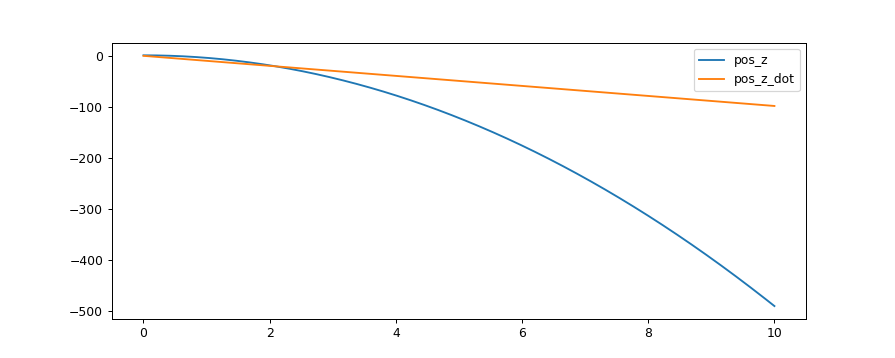

In [351]:
I_world = np.array([[1, 0, 0],
                    [0, 1, 0],
                    [0, 0, 1]])

r_left = np.array([[0, 0, 0],
                   [0, 0, 0],
                   [0, 0, 0]])
    
r_right = np.array([[0, 0, 0],
                    [0, 0, 0],
                    [0, 0, 0]])
    
f_left = np.array([[0],
                   [0],
                   [0]])
    
f_right = np.array([[0],
                    [0],
                    [0]])

x0 = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, -9.81]

def func(t, x):
    #print("t:", t)
    #print(x)
    
    x_t = np.array(x).reshape(13,1)
    
    I_world = np.array([[0.05, 0.01, 0.01],
                        [0.01, 0.4, 0.01],
                        [0.01, 0.01, 0.03]]) # Inertia in the world frame. See symbolic definiton with rotation matrix from body frame above.

    # Location of the force vector being applied by the left foot.
    r_x_left = 0.1
    r_y_left = 0
    r_z_left = 0

    # Location of the force vector being applied by the right foot.
    r_x_right = -0.1
    r_y_right = 0
    r_z_right = 0


    # Skew symmetric versions for the 3x1 foot position vector resembling the matrix version of the cross product of two vectors. This is needed for the matrix form.
    r_left_skew_symmetric = np.array([[0, -r_z_left, r_y_left],
                                  [r_z_left, 0, -r_x_left],
                                  [-r_y_left, r_x_left, 0]]) 
    
    r_right_skew_symmetric = np.array([[0, -r_z_right, r_y_right],
                                   [r_z_right, 0, -r_x_right],
                                   [-r_y_right, r_x_right, 0]]) 

    A_c_temp = np.array([[0, 0, 0, 0, 0, 0, math.cos(x_t[2]), math.sin(x_t[2]), 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, -math.sin(x_t[2]), math.cos(x_t[2]), 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                    
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                    
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                    
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

    B_c_temp = np.block([[0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [I_world @ r_left_skew_symmetric, I_world @ r_right_skew_symmetric],
                [1/m_value, 0, 0, 1/m_value, 0, 0],
                [0, 1/m_value, 0, 0, 1/m_value, 0],
                [0, 0, 1/m_value, 0, 0, 1/m_value],
                [0, 0, 0, 0, 0, 0]])
    
    A_t = np.array([[0, 0, 0, 0, 0, 0, math.cos(x_t[2]), math.sin(x_t[2]), 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, -math.sin(x_t[2]), math.cos(x_t[2]), 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                    
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                    
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                    
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
    
    temp_l = np.linalg.inv(I_world).dot(r_left)

    temp_r = np.linalg.inv(I_world).dot(r_right)

    B_t = np.array([[0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [temp_l[0][0], temp_l[0][1], temp_l[0][2], temp_r[0][0], temp_r[0][1], temp_r[0][2]],
                    [temp_l[1][0], temp_l[1][1], temp_l[1][2], temp_r[1][0], temp_r[1][1], temp_r[1][2]],
                    [temp_l[2][0], temp_l[2][1], temp_l[2][2], temp_r[2][0], temp_r[2][1], temp_r[2][2]],
                    [1/m_value, 0, 0, 1/m_value, 0, 0],
                    [0, 1/m_value, 0, 0, 1/m_value, 0],
                    [0, 0, 1/m_value, 0, 0, 1/m_value],
                    [0, 0, 0, 0, 0, 0]])
    
    u_t = np.array(np.array([[f_left[0][0]],
                             [f_left[1][0]],
                             [f_left[2][0]],
                             [f_right[0][0]],
                             [f_right[1][0]],
                             [f_right[2][0]]]))
    
    #print(B_t == B_c_temp)

    
    x_dot_t = A_t.dot(x_t) #+ B_t.dot(u_t)
    #print(x_dot_t.shape)
    #print(x_dot_t[0])
    
    return [x_dot_t[0][0], x_dot_t[1][0], x_dot_t[2][0], x_dot_t[3][0], x_dot_t[4][0], x_dot_t[5][0], x_dot_t[6][0], x_dot_t[7][0], x_dot_t[8][0], x_dot_t[9][0], x_dot_t[10][0], x_dot_t[11][0], x_dot_t[12][0]]


#func(0,x0)
#print("Test ran")

solution = scipy.integrate.solve_ivp(func, [0, 10], x0, max_step=.005) # , atol=0.0015, rtol=0.0015

print(solution.y[0].shape)

fig = plt.figure()
ax = fig.add_subplot(111)


#ax.plot(solution.t, solution.y[0],label="roll")
#ax.plot(solution.t, solution.y[1],label="pitch")
#ax.plot(solution.t, solution.y[2],label="yaw")
#ax.plot(solution.t, solution.y[3],label="pos_x")
#ax.plot(solution.t, solution.y[4],label="pos_y")
ax.plot(solution.t, solution.y[5],label="pos_z")
#ax.plot(solution.t, solution.y[6],label="omega_x")
#ax.plot(solution.t, solution.y[7],label="omega_y")
#ax.plot(solution.t, solution.y[8],label="omega_z")
#ax.plot(solution.t, solution.y[9],label="pos_x_dot")
#ax.plot(solution.t, solution.y[10],label="pos_y_dot")
ax.plot(solution.t, solution.y[11],label="pos_z_dot")
plt.legend()

In [9]:
def step_discrete_system(A_param, B_param, x0_param, u_param, t_param):
    states_param = [x0_param]
    
    time_range = np.arange((t_param * (1/dt)))
    
    print("k is:", time_range)
    
    for k in time_range:
        states_param.append(A_param.dot(states_param[-1]) + B_param.dot(u_param))
        
    return states_param